Import libraries and clean data

In [303]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

Load in data

In [304]:
data_read = pd.read_csv('All Trading Simulation Output.csv')
data_read = data_read.drop(columns=['Unnamed: 0'])
data_read['DateTime_Minute'] = pd.to_datetime(data_read['DateTime_Minute'], format='%Y-%m-%d %H:%M:%S')

signal_counts = data_read['Signal'].value_counts()
print(signal_counts)

Signal
Hold    36612
Buy     18861
Sell     7754
Name: count, dtype: int64


Get extra features 

In [305]:
# Add time
data_read['Hour'] = data_read['DateTime_Minute'].dt.hour
data_read['Minute'] = data_read['DateTime_Minute'].dt.minute
data_read['Second'] = data_read['DateTime_Minute'].dt.second

# Calculate moving averages for bid and ask prices
data_read['MA5_Bid'] = data_read['Bid1_Price'].rolling(window=5).mean()
data_read['MA10_Bid'] = data_read['Bid1_Price'].rolling(window=10).mean()
data_read['MA5_Ask'] = data_read['Ask1_Price'].rolling(window=5).mean()
data_read['MA10_Ask'] = data_read['Ask1_Price'].rolling(window=10).mean()

# Create lagged features
data_read['Weighted_Avg_Bid_Price_Lag1'] = data_read['Bid1_Price'].shift(1)
data_read['Weighted_Avg_Ask_Price_Lag1'] = data_read['Ask1_Price'].shift(1)

Make data cutes for Train, Val, Test

In [306]:
# Train: Jan - April
train_data = data_read[data_read['DateTime_Minute'] <= '2025-01-31'].copy()
# Val: May
#validation_data = data_read[(data_read['DateTime_Minute'] >= '2025-01-03') & (data_read['DateTime_Minute'] < '2025-01-04')].copy()
validation_data = data_read[(data_read['DateTime_Minute'] >= '2025-02-01') & (data_read['DateTime_Minute'] < '2025-02-10')].copy()
# Test: June
#test_data = data_read[(data_read['DateTime_Minute'] >= '2025-06-01') & (data_read['DateTime_Minute'] < '2025-07-01')].copy()
test_data = data_read[(data_read['DateTime_Minute'] >= '2025-02-10') & (data_read['DateTime_Minute'] < '2025-02-20')].copy()

Select Features and target variable

In [307]:
# define the target
target = 'Signal'

# Select features
features = ['Bid1_Price', 'Bid2_Price', 'Ask1_Price', 'Ask2_Price', 'Bid1_Volume', 'Ask1_Volume', 
            'Bid_Ask_Spread', 'Market_Depth_Bid', 'Market_Depth_Ask', 
            'Historical_Volatility', 'Cumulative_Volume_Difference', 'Order_imbalance', 
            'MA5_Bid', 'MA10_Bid', 'MA5_Ask', 'MA10_Ask', 'RSI', 'MACD', 
            'Weighted_Avg_Bid_Price_Lag1', 'Weighted_Avg_Ask_Price_Lag1']


X_train = train_data[features]
y_train = train_data[target]

X_val = validation_data[features]
y_val = validation_data[target]

X_test = test_data[features]
y_test = test_data[target]

Fill missing values with medians

In [308]:
# use SimpleImputer to impute medians
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)


Handle Class Imbalances using SMOTE

In [309]:
# use smote to resample training data so same number of signals
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

In [310]:
# Print the distribution of classes after SMOTE
print(y_train_resampled.value_counts())

Signal
Hold    8561
Buy     8561
Sell    8561
Name: count, dtype: int64


Scale Model (not neccesarily needed)

In [311]:
# scale data (not really needed for RF, but could be useful to expand to other models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

C:\Users\Tim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Tim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [312]:
# Count occurrences of each unique value in y_train_resampled
counts = y_train.value_counts()

# Print the number of "Buy" signals
print("Number of 'Buy' signals in y_train_resampled:", counts.get('Hold', 0))

Number of 'Buy' signals in y_train_resampled: 8561


In [313]:
# Fit a simple RF to assess feature importance
rf_simple = RandomForestClassifier(n_estimators=100, random_state=42)
rf_simple.fit(X_train_scaled, y_train_resampled)
importances = rf_simple.feature_importances_

# Print feature importance
feature_names = features
sorted_indices = np.argsort(importances)[::-1]
for idx in sorted_indices:
    print(f"{feature_names[idx]}: {importances[idx]:.2f}")

Bid_Ask_Spread: 0.17
Historical_Volatility: 0.13
Ask2_Price: 0.08
Ask1_Price: 0.07
MA10_Ask: 0.05
Bid2_Price: 0.05
MA10_Bid: 0.04
MA5_Ask: 0.04
Bid1_Price: 0.04
Weighted_Avg_Ask_Price_Lag1: 0.04
Ask1_Volume: 0.03
Market_Depth_Ask: 0.03
MA5_Bid: 0.03
Weighted_Avg_Bid_Price_Lag1: 0.03
RSI: 0.03
MACD: 0.03
Bid1_Volume: 0.03
Market_Depth_Bid: 0.03
Cumulative_Volume_Difference: 0.03
Order_imbalance: 0.02


Do Gridsearch to get best params

In [314]:
from sklearn.model_selection import GridSearchCV

# gridseach parameters
param_grid = {
    'n_estimators': [400, 500, 600],  # no.of trees
    'max_depth': [40, 50, 60],  # max depth of the tree
    'min_samples_split': [2, 5],  # min no. samples required to split an internal node
    'min_samples_leaf': [1, 2]  # min no. of samples required at a leaf node
}

# RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=2, scoring='accuracy', n_jobs=-1)

Print Best Params

In [315]:
# fit grid search
grid_search.fit(X_train_scaled, y_train_resampled)

# print best parameters and score from grid search
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-validation score: 0.86


Get validation accuracy using grid search parameters

In [324]:
# prediction and evaluation using scaled validation data
y_val_pred = grid_search.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.6970172684458399


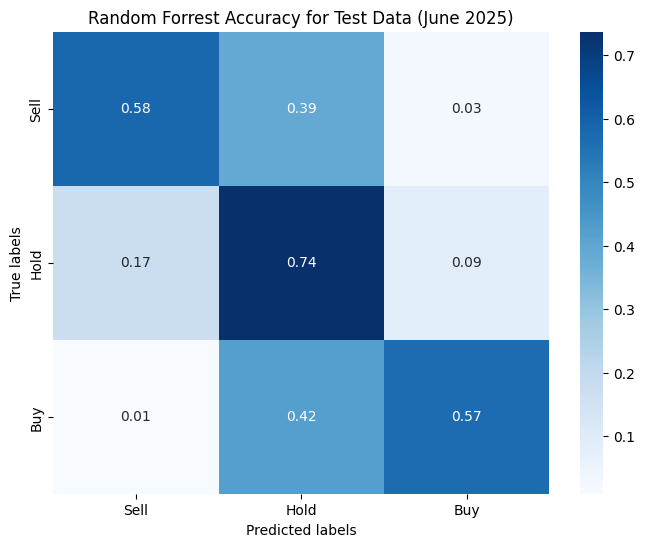

In [325]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_val_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap="Blues", fmt=".2f")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Random Forrest Accuracy for Test Data (June 2025)')
ax.xaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])
ax.yaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])

plt.show()

Do on Test Data

In [326]:
# Prediction and evaluation using scaled test data
y_test_pred = grid_search.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.6650318783717508


In [327]:
best_rf_model = grid_search.best_estimator_
# Prediction using the best model on the scaled test data
y_test_pred = best_rf_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.6650318783717508


Plot Result

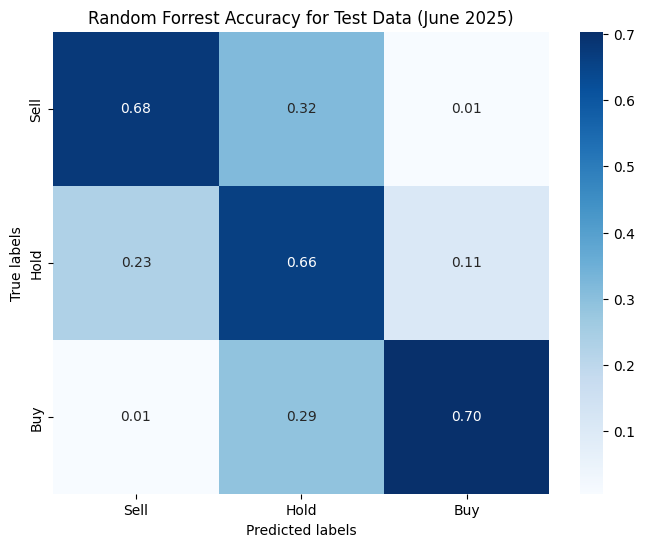

In [328]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, ax=ax, cmap="Blues", fmt=".2f")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Random Forrest Accuracy for Test Data (June 2025)')
ax.xaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])
ax.yaxis.set_ticklabels(['Sell', 'Hold', 'Buy'])

plt.show()

In [321]:
# Prediction and evaluation using scaled test data
y_test_pred = grid_search.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.6650318783717508


Plot the tree

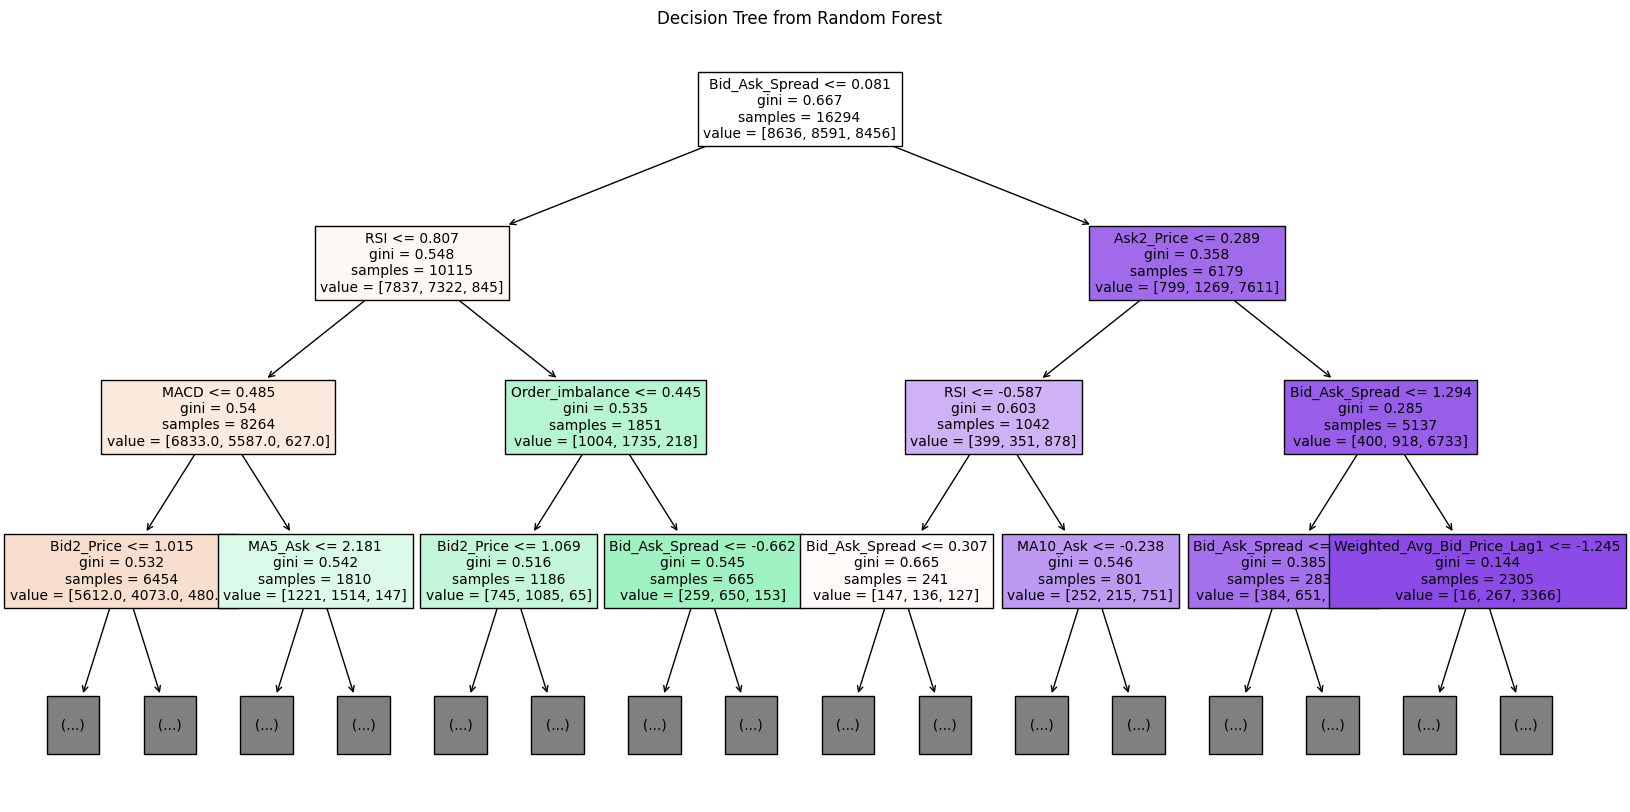

In [322]:
from sklearn.tree import plot_tree

best_rf_model = grid_search.best_estimator_
# Select the first tree

first_tree = best_rf_model.estimators_[0]
# Plot the tree
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(first_tree, filled=True, feature_names=features, max_depth=3, fontsize=10, ax=ax)
plt.title("Decision Tree from Random Forest")
plt.show()

In [323]:
# Calculate correlations with the target
correlations = data_read.corr()  # Assumes target is encoded if it's categorical

# Print correlations with the target
print(correlations['Signal'].sort_values(ascending=False))

# Alternatively, visualize correlations
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.show()

ValueError: could not convert string to float: 'Hold'